Notebook by Paul Scotti with code heavily adapted from 
Aidan Dempster (https://github.com/Veldrovive/open_clip) (in particular, various networks for 3d voxels, transformers, etc. here: https://github.com/Veldrovive/open_clip/blob/main/src/open_clip/model.py)

Important modifications subsequently made by Jimmie Goode (https://github.com/jimgoo) 

# Import packages & functions

In [1]:
import os
import sys
import math
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mean=np.array([0.48145466, 0.4578275, 0.40821073])
std=np.array([0.26862954, 0.26130258, 0.27577711])
denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))
def torch_to_Image(x,device=device):
    x = denorm(x)
    return transforms.ToPILImage()(x)
def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5
def torch_to_matplotlib(x,device=device):
    if torch.mean(x)>10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]
def pairwise_cosine_similarity(A, B, dim=1, eps=1e-8):
    #https://stackoverflow.com/questions/67199317/pytorch-cosine-similarity-nxn-elements
    numerator = A @ B.T
    A_l2 = torch.mul(A, A).sum(axis=dim)
    B_l2 = torch.mul(B, B).sum(axis=dim)
    denominator = torch.max(torch.sqrt(torch.outer(A_l2, B_l2)), torch.tensor(eps))
    return torch.div(numerator, denominator)
def batchwise_cosine_similarity(Z,B):
    # https://www.h4pz.co/blog/2021/4/2/batch-cosine-similarity-in-pytorch-or-numpy-jax-cupy-etc
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity
def get_non_diagonals(a):
    a = torch.triu(a,diagonal=1)+torch.tril(a,diagonal=-1)
    # make diagonals -1
    a=a.fill_diagonal_(-1)
    return a
def topk(similarities,labels,k=5):
    if k > similarities.shape[0]:
        k = similarities.shape[0]
    topsum=0
    for i in range(k):
        topsum += torch.sum(torch.argsort(similarities,axis=1)[:,-(i+1)] == labels)/len(labels)
    return topsum
torch.manual_seed(0)
np.random.seed(0)

cuda


## Checking if you are debugging or training the full model with multi-gpu

In [2]:
# use large batches and the complete training dataset? 
full_training = True
print('full_training',full_training)

full_training True


In [3]:
# Setup multi-gpu PyTorch distributed parallel processing (ddp) if multiple gpus are found
try:
    # set up multi-gpu distributed parallel processing
    import torch.distributed as dist
    from torch.nn.parallel import DistributedDataParallel as DDP
    from socket import gethostname

    rank          = int(os.environ["SLURM_PROCID"])
    world_size    = int(os.environ["WORLD_SIZE"])
    gpus_per_node = int(os.environ["SLURM_GPUS_ON_NODE"])
    assert gpus_per_node == torch.cuda.device_count()
    print(f"Hello from rank {rank} of {world_size} on {gethostname()} where there are" \
          f" {gpus_per_node} allocated GPUs per node.", flush=True)

    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    if rank == 0: print(f"Group initialized? {dist.is_initialized()}", flush=True)

    local_rank = rank - gpus_per_node * (rank // gpus_per_node)
    print("local rank",local_rank)
    torch.cuda.set_device(local_rank)
    using_ddp = True
except:
    local_rank = 0
    using_ddp = False
print("using_ddp:",using_ddp)
if using_ddp:
    print("DistributedDataParallel enabled!")
else:
    print("NOT using distributed parallel processing!")

using_ddp: False
NOT using distributed parallel processing!


**Example DDP-enabled .slurm script for reference:**

Convert this jupyter notebook to .py with 

jupyter nbconvert --to script Voxel_to_CLIPvoxel_ddp.ipynb

then create a .slurm file with the following contents:

In [11]:
# !/bin/bash
# SBATCH --job-name=clipvox      #create a short name for your job
# SBATCH --nodes=1               #node count
# SBATCH --ntasks-per-node=2    #with DDP, must equal num of gpus
# SBATCH --cpus-per-task=8     #rule-of-thumb is 4 times number of gpus
# SBATCH --gres=gpu:2  
# SBATCH --mem-per-gpu=40G     
# SBATCH --time=00:10:00       #total run time limit (HH:MM:SS)
# SBATCH --mail-type=begin,end,fail         
# SBATCH --mail-user=your_email@gmail.com
# export MASTER_PORT=$(expr 10000 + $(echo -n $SLURM_JOBID | tail -c 4))
# export WORLD_SIZE=$(($SLURM_NNODES * $SLURM_NTASKS_PER_NODE))
# echo "WORLD_SIZE="$WORLD_SIZE
# master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
# export MASTER_ADDR=$master_addr
# echo "MASTER_ADDR="$MASTER_ADDR
# srun python Voxel_to_CLIPvoxel.py

## Which pretrained model are you using for voxel alignment to embedding space? 

In [6]:
model_name = 'clip_image_vit' # CLIP ViT-L/14 image embeddings

# model_name = 'clip_text_vit' # CLIP ViT-L/14 text embeddings

# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")

Using model: clip_image_vit


In [ ]:
if model_name=='clip_image_vit':
    model, preprocess = clip.load("ViT-L/14", device=device)
    emb_name = "images"
elif model_name=='clip_text_vit':
    model, preprocess = clip.load("ViT-L/14", device=device)
    emb_name = "trial"
elif model_name=='clip_image_resnet':
    model, preprocess = clip.load("RN50", device=device)
    emb_name = "images"
    
# dont want to train model
model.eval()
# dont need to calculate gradients
for param in model.parameters():
    param.requires_grad = False
    
# prep embedder function which returns CLIP embeddings for given input
if model_name=='clip_text_vit':    
    def embedder(text_token):
        with torch.no_grad():
            text_features = model.encode_text(text_token.to(device))
            text_features = torch.clamp(text_features, -1.5, 1.5)
            text_features = nn.functional.normalize(text_features, dim=-1)
        return text_features
else:
    def embedder(image):
        with torch.no_grad():
            image_features = model.encode_image(image.to(device))
            image_features = torch.clamp(image_features, -1.5, 1.5)
            image_features = nn.functional.normalize(image_features, dim=-1)
        return image_features     
    
# text model specific functions
def text_tokenize(annots):
    for i,b in enumerate(annots):
        t = ''
        while t == '':
            rand = torch.randint(5,(1,1))[0][0]
            t = b[0,rand]
        if i==0:
            txt = np.array(t)
        else:
            txt = np.vstack((txt,t))
    txt = txt.flatten()
    return clip.tokenize(txt)

# load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
subj01_order = f['subj01'][:]
f.close()
annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
subj01_annots = annots[subj01_order]

# Load data

NSD webdatasets for subjects 1, 2, and 3 are publicly available here: 

https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset

In [11]:
preproc_vox = transforms.Compose([transforms.ToTensor(),torch.nan_to_num])

preproc_img = transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.Normalize(mean=mean,
                                         std=std),
                ])

# image augmentation just for the CLIP image model that will be more semantic-focused
img_augment = transforms.Compose([
                    transforms.RandomCrop(size=(140,140)),
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(p=.5),
                    transforms.ColorJitter(.4,.4,.2,.1),
                    transforms.RandomGrayscale(p=.2),
                ])

if not full_training: 
    num_devices = 1
    num_workers = 1
    print("num_workers",num_workers)
    batch_size = 16
    print("batch_size",batch_size)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..1}.tar"
else:
    num_devices = torch.cuda.device_count()
    print("num_devices",num_devices)
    num_workers = num_devices
    print("num_workers",num_workers)
    batch_size = 300
    print("batch_size",batch_size)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"

train_data = wds.DataPipeline([wds.ResampledShards(train_url),
                    wds.tarfile_to_samples(),
                    wds.shuffle(500,initial=500),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

# check that your data loaders are working
for train_i, (voxel, emb) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape)
    if emb_name=='images': # image embedding
        emb = emb.to(device)
    else: # text embedding
        text_tokens = text_tokenize(subj01_annots[emb]).to(device)
    print("emb.shape",emb.shape)
    emb = embedder(emb)
    print("emb.shape",emb.shape)
    out_dim = emb.shape[1]
    print("out_dim", out_dim)
    break

num_devices 1
num_workers 4
batch_size 30
global_batch_size 30
num_worker_batches 208
validation: num_worker_batches 5
idx 0
voxel.shape torch.Size([30, 15724])
emb.shape torch.Size([30, 3, 224, 224])
emb.shape torch.Size([30, 768])
out_dim 768


# Initialize model

In [12]:
class BrainNetwork(nn.Module):
    def __init__(self,
                 out_dim,
                 input_size=15724,
                 h1=4096,
                 h2=2048,
                 h3=1024,
                 pdrop=0.1,
    ):
        super().__init__()
        
        self.mlp = nn.Sequential(
            #torch.nn.BatchNorm1d(input_size),
            nn.Linear(input_size, h1),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h3, out_dim),
        )
        
    def forward(self, x):
        return self.mlp(x)

# class BrainNetwork(nn.Module):
#     def __init__(self, out_dim, h=7861):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
#             nn.Dropout1d(0.1),
#             nn.ReLU(),
#             nn.AvgPool1d(kernel_size=2, stride=2)
#         )
#         self.lin = nn.Linear(h,h)
#         self.relu = nn.ReLU()
#         self.lin1 = nn.Linear(251552,out_dim)
        
#     def forward(self, x):
#         x = x[:,None,:]
#         x = self.conv(x)
#         residual = x
#         for res_block in range(4):
#             x = self.lin(x)
#             x += residual
#             x = self.relu(x)
#             residual = x
#         x = x.reshape(len(x),-1)
#         x = self.lin1(x)
#         return x

brain_net = BrainNetwork(out_dim) 

In [13]:
if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

# test out that the neural network can run without error:
with torch.cuda.amp.autocast():
    out = brain_net(voxel.to(device))
    print(out.shape)

RuntimeError: Default process group has not been initialized, please make sure to call init_process_group.

# Start model training

In [14]:
if using_ddp:
    num_epochs = 1000 # basically until the time limit on my slurm job runs out
else:
    num_epochs = 20

initial_learning_rate = 3e-5
optimizer = torch.optim.AdamW(brain_net.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(brain_net.parameters(), lr=initial_learning_rate, momentum=0.95)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-8, patience=10) 

# loss function
nce = InfoNCE()
# cos = nn.CosineSimilarity()
# mse = nn.MSELoss()

In [15]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")

if full_training:
    print(f"Will be saving model checkpoints to checkpoints/{model_name}_subj01_epoch#.pth")
else:
    print(f"Warning: not saving model checkpoints")

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

epoch = 0
train_losses = []; val_losses = []
train_topk = []; val_topk = []
lrs = []
epoch_logs = []

pbar = tqdm(range(epoch,num_epochs),ncols=250)
for epoch in pbar:
    brain_net.train()
    similarities = []
    for train_i, (voxel, emb) in enumerate(train_dl):
        optimizer.zero_grad()
        
        voxel = voxel.to(device)
        
        with torch.cuda.amp.autocast():
            if emb_name=='images': # image embedding
                emb = embedder(emb.to(device)) #embedder(img_augment(emb.to(device)))
            else: # text embedding
                text_tokens = text_tokenize(subj01_annots[emb]).to(device)
                emb = embedder(text_tokens)

            emb_ = brain_net(voxel)
            if torch.any(torch.isnan(emb_)):
                raise ValueError("NaN found...")
            emb_ = nn.functional.normalize(emb_,dim=-1) # l2 normalization on the embeddings
            
            labels = torch.arange(len(emb)).to(device)
            loss = nce(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
            
            similarities = batchwise_cosine_similarity(emb,emb_)

            percent_correct = topk(similarities,labels,k=1)
            
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_topk.append(percent_correct.item())
        
    brain_net.eval()    
    for val_i, (val_voxel, val_emb) in enumerate(val_dl):
        with torch.no_grad(): 
            val_voxel = val_voxel.to(device)
            
            with torch.cuda.amp.autocast():
                if emb_name=='images': # image embedding
                    val_emb = embedder(val_emb.to(device)) # not doing augmentations for val
                else: # text embedding
                    val_text_tokens = text_tokenize(subj01_annots[val_emb]).to(device)
                    val_emb = embedder(val_text_tokens)

                val_emb_ = brain_net(val_voxel)
                val_emb_ = nn.functional.normalize(val_emb_,dim=-1) # l2 normalization on the embeddings
            
                labels = torch.arange(len(val_emb)).to(device)

                val_loss = nce(val_emb_.reshape(len(val_emb),-1),val_emb.reshape(len(val_emb),-1))

                val_similarities = batchwise_cosine_similarity(val_emb,val_emb_)

                val_percent_correct = topk(val_similarities,labels,k=1)
                
            val_losses.append(val_loss.item())
            val_topk.append(val_percent_correct.item())
                
    if epoch%5==0 and full_training:
        print(f'saving checkpoints/{model_name}_subj01_epoch{epoch}.pth...')
        if (using_ddp==False) or (using_ddp==True and local_rank==0):
            state_dict = brain_net.state_dict()
            if using_ddp: # if using DDP, convert DDP to non-DDP before saving
                for key in list(state_dict.keys()):
                    if 'module.' in key:
                        state_dict[key.replace('module.', '')] = state_dict[key]
                        del state_dict[key]   
            torch.save({
                'epoch': epoch,
                'model_state_dict': state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_topk': train_topk,
                'val_topk': val_topk,
                'lrs': lrs,
                }, f'checkpoints/{model_name}_subj01_epoch{epoch}.pth')
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
            
    scheduler.step(val_loss) 
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # logging the average results across batches for current epoch
    logs = OrderedDict(
        loss=np.mean(train_losses[-(train_i+1):]),
        topk=np.mean(train_topk[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
        val_topk=np.mean(val_topk[-(val_i+1):]),
        lr=lrs[-1],
    )
    pbar.set_postfix(**logs)
    epoch_logs.append(logs)
    pd.DataFrame(epoch_logs).to_csv(f'checkpoints/{model_name}_subj01.epoch-logs.csv')
    
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2022-11-22 11:29:52
num_epochs:1000 batch_size:300 lr:0.0003
Will be saving model checkpoints to checkpoints/clip_image_vit_subj01_epoch#.pth


  0%|                                                                                                                                                                                                                            | 0/1000 [00:00<?, ?it/s]

saving checkpoints/clip_image_vit_subj01_epoch0.pth...


  0%|▏                                                                                                                                              | 1/1000 [02:51<47:41:27, 171.86s/it, loss=4.47, lr=0.0003, topk=0.0805, val_loss=4.11, val_topk=0.13]/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py:9: UserWarning: is_namedtuple is deprecated, please use the python checks instead
  warnings.warn("is_namedtuple is deprecated, please use the python checks instead")
  0%|▏                                                                                                                                              | 1/1000 [03:13<53:37:15, 193.23s/it, loss=4.47, lr=0.0003, topk=0.0805, val_loss=4.11, val_topk=0.13]


KeyboardInterrupt: 

Plotting results from checkpoints/clip_image_vit_subj01_epoch0.pth


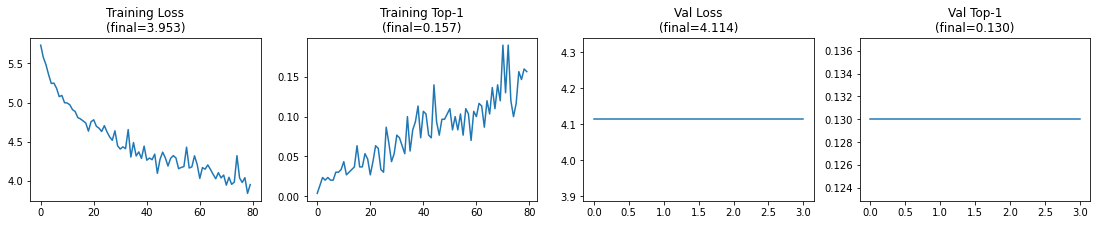

In [16]:
# # Loading checkpoint  
ckpt_path = 'checkpoints/clip_image_vit_subj01_epoch0.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Plotting results from {ckpt_path}")
train_losses=checkpoint['train_losses']
train_topk=checkpoint['train_topk']
val_losses=checkpoint['val_losses']
val_topk=checkpoint['val_topk']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(19,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]:.3f})")
ax1.plot(train_losses)
ax2.set_title(f"Training Top-1\n(final={train_topk[-1]:.3f})")
ax2.plot(train_topk)
ax3.set_title(f"Val Loss\n(final={val_losses[-1]:.3f})")
ax3.plot(val_losses)
ax4.set_title(f"Val Top-1\n(final={val_topk[-1]:.3f})")
ax4.plot(val_topk)
plt.show()

# Evaluating Top-K Image Retrieval
Restart kernel, import packages, then skip to here and run below cells.

In [2]:
num_samples = 492
batch_size = 300
num_batches = 1
num_workers = 1
num_worker_batches = 1

preproc_vox = transforms.Compose([transforms.ToTensor(),torch.nan_to_num])
preproc_img = transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.Normalize(mean=mean,
                                         std=std),
                ])

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", "images", "trial"),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

In [3]:
clip_model, _ = clip.load("ViT-L/14", device=device)
resnet_model, _ = clip.load("RN50", device=device)
clip_model.eval()
resnet_model.eval()

def clip_text_embedder(text_token):
    with torch.no_grad():
        text_features = clip_model.encode_text(text_token.to(device))
        text_features = torch.clamp(text_features,-1.5,1.5)
        text_features = nn.functional.normalize(text_features, dim=-1)
    return text_features

def clip_image_embedder(image):
    with torch.no_grad():
        image_features = clip_model.encode_image(image.to(device))
        image_features = torch.clamp(image_features,-1.5,1.5) 
        image_features = nn.functional.normalize(image_features, dim=-1)
    return image_features    

def resnet_image_embedder(image):
    with torch.no_grad():
        image_features = resnet_model.encode_image(image.to(device))
        image_features = torch.clamp(image_features,-1.5,1.5) 
        image_features = nn.functional.normalize(image_features, dim=-1)
    return image_features  

In [4]:
brain_net = BrainNetwork(768) 

brain_net_clip_img = brain_net.to(device)
checkpoint = torch.load('clip_image_vit_subj01.pth', map_location=device)
brain_net_clip_img.load_state_dict(state_dict)
brain_net_clip_img.eval()

brain_net_clip_text = brain_net.to(device)
checkpoint = torch.load('clip_text_vit_subj01.pth', map_location=device)
brain_net_clip_text.load_state_dict(state_dict)
brain_net_clip_text.eval()

brain_net = BrainNetwork(1024) 
brain_net_resnet_img = brain_net.to(device)
checkpoint = torch.load('clip_image_resnet_subj01.pth', map_location=device)
brain_net_resnet_img.load_state_dict(state_dict)
brain_net_resnet_img.eval()

BrainNetwork(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): Dropout1d(p=0.1, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin): Linear(in_features=7861, out_features=7861, bias=True)
  (relu): ReLU()
  (lin1): Linear(in_features=251552, out_features=1024, bias=True)
)

CLIP IMG
percent_correct tensor(0.1233, device='cuda:0')


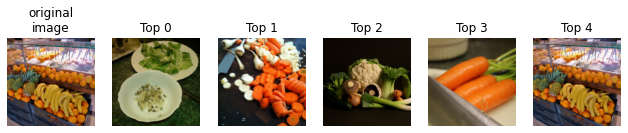

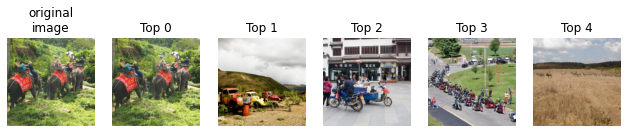

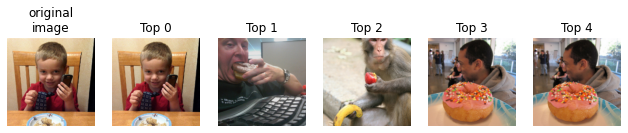

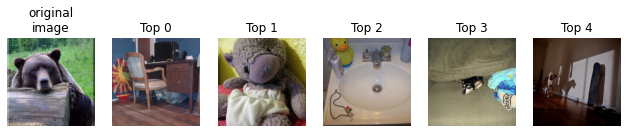


RESNET50 IMG
percent_correct tensor(0.1800, device='cuda:0')


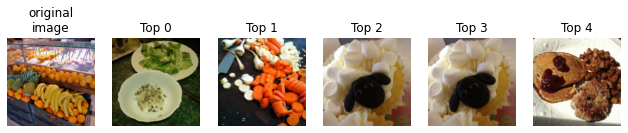

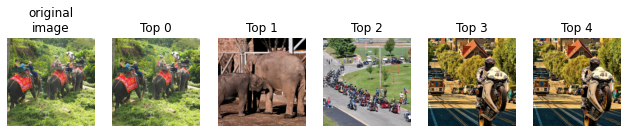

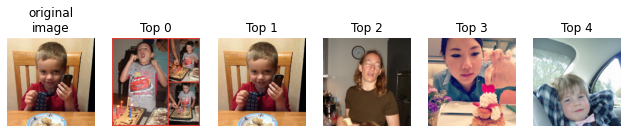

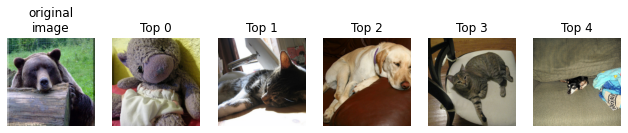


CLIP TEXT
percent_correct tensor(0.1267, device='cuda:0')


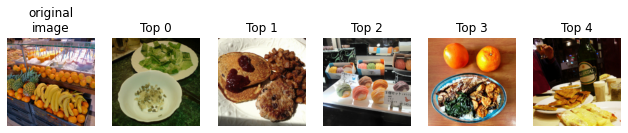

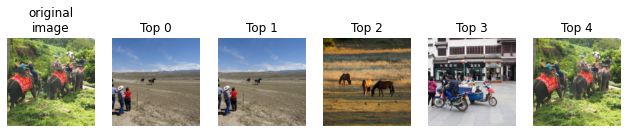

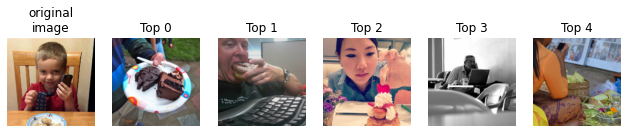

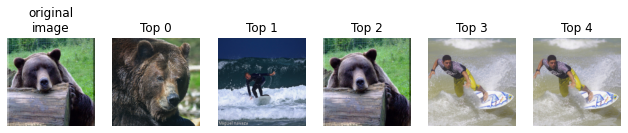


COMBINED
percent_correct tensor(0.2733, device='cuda:0')


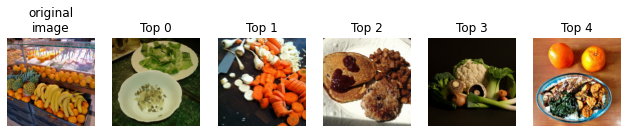

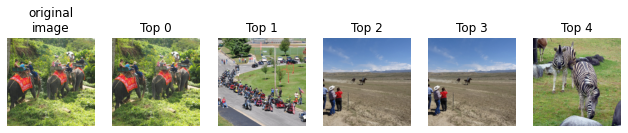

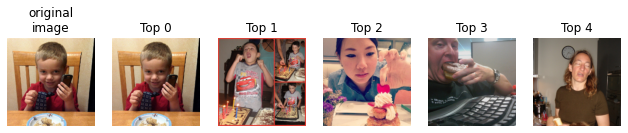

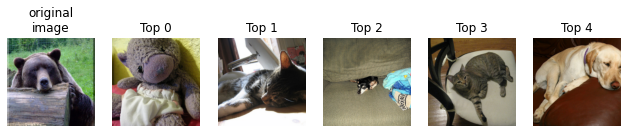

In [5]:
minibatch = 10 # using minibatches to be able to run evaluation on much weaker gpu
for train_i, (voxel, emb, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            embt = text_tokenize(subj01_annots[trial]).to(device)
            
            emb0=[]; emb1 = []; emb2 =[]
            for m in np.arange(0,batch_size,minibatch):
                if m==0:
                    emb0 = clip_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    emb1 = resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    emb2 = clip_text_embedder(embt[m:m+minibatch]).detach().cpu()
                else:
                    emb0 = torch.vstack((emb0,clip_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    emb1 = torch.vstack((emb1,resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    emb2 = torch.vstack((emb2,clip_text_embedder(embt[m:m+minibatch]).detach().cpu()))

            emb0 = emb0.to(device)
            emb1 = emb1.to(device)
            emb2 = emb2.to(device)
            
            emb_0 = nn.functional.normalize(brain_net_clip_img(voxel),dim=-1)
            emb_1 = nn.functional.normalize(brain_net_resnet_img(voxel),dim=-1)
            emb_2 = nn.functional.normalize(brain_net_clip_text(voxel),dim=-1)
            
            labels = torch.arange(len(emb0)).to(device)
            similarities0 = batchwise_cosine_similarity(emb0,emb_0)
            similarities1 = batchwise_cosine_similarity(emb1,emb_1)
            similarities2 = batchwise_cosine_similarity(emb2,emb_2)
            
            similaritiesx = similarities0/1.3+similarities1+similarities2/2

            print("CLIP IMG")
            
            percent_correct = topk(similarities0,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities0=np.array(similarities0.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities0[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nRESNET50 IMG")
            
            percent_correct = topk(similarities1,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities1=np.array(similarities1.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities1[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nCLIP TEXT")
            
            percent_correct = topk(similarities2,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities2=np.array(similarities2.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities2[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nCOMBINED")
            
            percent_correct = topk(similaritiesx,labels,k=1)
            print("percent_correct",percent_correct)
            
            similaritiesx=np.array(similaritiesx.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similaritiesx[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()